In [1]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import umap
import os
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from scipy.stats import ttest_ind
from scipy.spatial import distance_matrix

import argparse
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.ensemble import GradientBoostingRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingCAC

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari, silhouette_score
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import MultiHeadIDEC,  target_distribution
from utils import *

# Utils.py

In [2]:
## Utils.py
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import linear_sum_assignment as linear_assignment
from read_patients import get_aki

color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

DATASETS = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes', 'respiratory',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'kidney', 'infant', 'wid_mortality']

DATA_DIR = "/Users/shivin/Document/NUS/Research/Data"
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/DeepCAC"

def load_mnist(path='./data/mnist.npz'):
    f = np.load(path)

    x_train, y_train, x_test, y_test = f['x_train'], f['y_train'], f[
        'x_test'], f['y_test']
    f.close()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test)).astype(np.int32)
    x = x.reshape((x.shape[0], -1)).astype(np.float32)
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y


class MnistDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_mnist()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


def load_mnist(path='./data/mnist.npz'):
    f = np.load(path)

    x_train, y_train, x_test, y_test = f['x_train'], f['y_train'], f[
        'x_test'], f['y_test']
    f.close()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test)).astype(np.int32)
    x = x.reshape((x.shape[0], -1)).astype(np.float32)
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y


class MnistDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_mnist()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


def is_non_zero_file(fpath):
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0


class parameters(object):
    def __init__(self, parser):
        self.input_dim = -1
        self.dataset = parser.dataset
        
        # Training parameters
        self.lr = parser.lr
        self.alpha = float(parser.alpha)
        self.wd = parser.wd
        self.batch_size = parser.batch_size
        self.n_epochs = parser.n_epochs
        self.pre_epoch = parser.pre_epoch
        self.pretrain = parser.pretrain
        self.load_ae = parser.load_ae
        self.classifier = parser.classifier
        self.tol = parser.tol

        # Model parameters
        self.lamda = parser.lamda
        self.beta = parser.beta
        self.gamma = parser.gamma
        self.delta = parser.delta
        self.hidden_dims = parser.hidden_dims
        self.latent_dim = self.n_z = parser.n_z
        self.n_clusters = parser.n_clusters
        self.clustering = parser.clustering
        self.n_classes = parser.n_classes

        # Utility parameters
        self.device = parser.device
        self.log_interval = parser.log_interval
        self.pretrain_path = parser.pretrain_path + "/" + self.dataset + ".pth"


#######################################################
# Evaluate Critiron
#######################################################


def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row, col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row, col)]) * 1.0 / y_pred.size


def plot(model, X_train, y_train, X_test=None, y_test=None, labels=None):
    reducer = umap.UMAP(random_state=42)
#     idx = torch.Tensor(np.random.randint(0,len(X_train),\
#                         int(0.1*len(X_train)))).type(torch.LongTensor).to(device)
    idx = range(int(0.2*len(X_train)))
    qs, latents_X = model(X_train[idx], output="latent")
    q_train = qs[0]
    y_train = y_train[idx]

    if labels is not None:
        cluster_id_train = labels[idx]
    else:
        cluster_id_train = torch.argmax(q_train, axis=1)

    X2 = reducer.fit_transform(latents_X.cpu().detach().numpy())

    print("Training data")

    c_clusters = [color[int(cluster_id_train[i])] for i in range(len(cluster_id_train))]
    c_labels = [color[int(y_train[i])] for i in range(len(cluster_id_train))]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Clusters vs Labels')
    ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
    ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
    plt.show()
    if X_test is not None:
        qs, latents_test = model(X_test, output="latent")
        q_test = qs[0]
        X2 = reducer.transform(latents_test.cpu().detach().numpy())
        cluster_id_test = torch.argmax(q_test, axis=1)
        c_clusters = [color[int(cluster_id_test[i])] for i in range(len(cluster_id_test))]
        c_labels = [color[int(y_test[i])] for i in range(len(cluster_id_test))]

        print("Test data")
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

def get_dataset(DATASET, DATA_DIR):
    if DATASET == "cic":
        Xa = pd.read_csv(DATA_DIR + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(DATA_DIR + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(DATA_DIR + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.fit_transform(Xb)
        Xc = scale.fit_transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()
        columns = cols

    elif DATASET == "titanic":
        X_train = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X_train.csv")
        columns = X_train.columns
        X_train = X_train.to_numpy()
        X_test = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()
    
    elif DATASET == "infant":
        X = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X.csv")
        columns = X.columns
        X = X.to_numpy()
        y = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        y = y.astype(int)
        enc = OneHotEncoder(handle_unknown='ignore')
        X = enc.fit_transform(X).toarray()
    
    elif DATASET == "kidney":
        print("Fetching Kidney Dataset")
        data = get_aki(DATA_DIR)
        X = pd.concat(data,axis=1).T
        columns = X.columns

        data_columns = list(columns[1:90]) + ['y'] # get the columns which have data, not mask
        non_binary_columns = data_columns[:81] # only these columns have non-binary data fit for scaling

        X = X.fillna(0)
        X = X[data_columns]

        y = X['y'].to_numpy().astype(int)
        X = X.drop(columns=['y'])

        scaler = MinMaxScaler()
        X[non_binary_columns] = scaler.fit_transform(np.nan_to_num(X[non_binary_columns]))
        X = X.to_numpy()
        os.chdir(BASE_DIR)

    elif DATASET == "respiratory":
        print("Fetching Respiratory Dataset")
        data = get_aki(DATA_DIR)
        X = pd.concat(data,axis=1).T
        columns = X.columns

        data_columns = list(columns[1:90]) + ['y'] # get the columns which have data, not mask
        non_binary_columns = data_columns[:81] # only these columns have non-binary data fit for scaling

        X = X.fillna(0)
        X = X[data_columns]

        y = X['y'].to_numpy().astype(int)
        X = X.drop(columns=['y'])

        scaler = MinMaxScaler()
        X[non_binary_columns] = scaler.fit_transform(np.nan_to_num(X[non_binary_columns]))
        X = X.to_numpy()
        os.chdir(BASE_DIR)

    else:
        X = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X.csv")
        columns = X.columns
        X = X.to_numpy()
        y = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
    return X, y, columns


def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    columns = ["feature_"+str(i) for i in range(n_features)]
    return X, np.array(Y).astype('int'), columns


def get_train_val_test_loaders(args):
    if args.dataset in DATASETS:
        if args.dataset != "kidney" and args.dataset != "respiratory":
            print("Loading Dataset ", args.dataset)
            if args.dataset == "synthetic":
                n_feat = 45
                X, y, columns = create_imbalanced_data_clusters(n_samples=5000,\
                       n_clusters=args.n_clusters, n_features = n_feat,\
                       inner_class_sep=0.2, outer_class_sep=2, seed=0)
                args.input_dim = n_feat

            elif args.dataset == "paper_synthetic":
                n_feat = 100
                X, y = paper_synthetic(2500, centers=4)
                args.input_dim = n_feat
                print(args.input_dim)

            else:
                X, y, columns = get_dataset(args.dataset, DATA_DIR)
                print(args.dataset)
                args.input_dim = X.shape[1]

            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_val = sc.fit_transform(X_val)
            X_test = sc.fit_transform(X_test)
            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))

        elif args.dataset == "kidney":
            print("Loading Kidney Train")
            X_train, y_train, columns = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/aki/train")
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            args.input_dim = X_train.shape[1]
            print(args.input_dim)

            print("Loading Kidney Test")
            X_test, y_test, columns = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/aki/test")

            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))

        else:
            print("Loading Repiratory Train")
            X_train, y_train, columns = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/ards/train")
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            args.input_dim = X_train.shape[1]
            print(args.input_dim)

            print("Loading Respiratory Test")
            X_test, y_test, columns = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/ards/test")

            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))
            
        train_loader = torch.utils.data.DataLoader(X_train_data_loader,
            batch_size=args.batch_size, shuffle=True)

        val_loader = torch.utils.data.DataLoader(X_val_data_loader,
            batch_size=args.batch_size, shuffle=True)

        test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
            batch_size=args.batch_size, shuffle=False)

        return columns, (X_train, y_train, train_loader), (X_val, y_val, val_loader), (X_test, y_test, test_loader)
    else:
        return None


def paper_synthetic(n_pts=1000, centers=4):
    X, y = make_blobs(n_pts, centers=centers)
    W = np.random.randn(10,2)
    U = np.random.randn(100,10)
    X1 = W.dot(X.T)
    X1 = X1*(X1>0)
    X2 = U.dot(X1)
    X2 = X2*(X2>0)
    return X2.T, y

In [3]:
def draw_graph(start, watch=[]):
    from graphviz import Digraph

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    graph = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

    assert(hasattr(start, "grad_fn"))
    if start.grad_fn is not None:
        _draw_graph(loss.grad_fn, graph, watch=watching)

    size_per_element = 0.15
    min_size = 12

    # Get the approximate number of nodes and edges
    num_rows = len(graph.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    graph.graph_attr.update(size=size_str)
    graph.render(filename='net_graph.jpg')


def _draw_graph(var, graph, watch=[], seen=[], indent="", pobj=None):
    ''' recursive function going through the hierarchical graph printing off
    what we need to see what autograd is doing.'''
    from rich import print
    
    if hasattr(var, "next_functions"):
        for fun in var.next_functions:
            joy = fun[0]
            if joy is not None:
                if joy not in seen:
                    label = str(type(joy)).replace(
                        "class", "").replace("'", "").replace(" ", "")
                    label_graph = label
                    colour_graph = ""
                    seen.append(joy)

                    if hasattr(joy, 'variable'):
                        happy = joy.variable
                        if happy.is_leaf:
                            label += " \U0001F343"
                            colour_graph = "green"

                            for (name, obj) in watch:
                                if obj is happy:
                                    label += " \U000023E9 " + \
                                        "[b][u][color=#FF00FF]" + name + \
                                        "[/color][/u][/b]"
                                    label_graph += name
                                    
                                    colour_graph = "blue"
                                    break

                            vv = [str(obj.shape[x])
                                  for x in range(len(obj.shape))]
                            label += " [["
                            label += ', '.join(vv)
                            label += "]]"
                            label += " " + str(happy.var())

                    graph.node(str(joy), label_graph, fillcolor=colour_graph)
                    print(indent + label)
                    _draw_graph(joy, graph, watch, seen, indent + ".", joy)
                    if pobj is not None:
                        graph.edge(str(pobj), str(joy))

In [28]:
import numpy as np
import torch

class EarlyStoppingCAC:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='./pretrained_model/checkpoint', dataset="", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = [None, None]
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path + "_" + dataset
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score[0] is None:
            self.best_score[0] = score[0]
            self.save_checkpoint(val_loss, model)

        if self.best_score[1] is None:
            self.best_score[1] = score[1]
            self.save_checkpoint(val_loss, model)

        if score[1] < self.best_score[1] + self.delta :
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.ae.state_dict(), self.path+".pt")
        for j in range(model.n_clusters):
            torch.save(model.classifiers[j][0].state_dict(), self.path+"_"+str(j)+".pt")
        self.val_loss_min = val_loss
        torch.save(model.cluster_layer, self.path+"_cc"+".pt")
        torch.save(model.p_cluster_layer, self.path+"_pc"+".pt")
        torch.save(model.n_cluster_layer, self.path+"_nc"+".pt")

    def load_checkpoint(self, model):
        print("Loading Best model with score: ", self.best_score)
        model.ae.load_state_dict(torch.load(self.path+".pt"))
        for j in range(model.n_clusters):
            model.classifiers[j][0].load_state_dict(torch.load(self.path+"_"+str(j)+".pt"))
        model.cluster_layer = torch.load(self.path+"_cc"+".pt")
        model.p_cluster_layer = torch.load(self.path+"_pc"+".pt")
        model.n_cluster_layer = torch.load(self.path+"_nc"+".pt")
        return model


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='./pretrained_model/checkpoint', dataset="", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = [None, None]
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path + "_" + dataset
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score[0] is None:
            self.best_score[0] = score[0]
            self.save_checkpoint(val_loss, model)

        if self.best_score[1] is None:
            self.best_score[1] = score[1]
            self.save_checkpoint(val_loss, model)

        if score[1] < self.best_score[1] + self.delta :
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path+".pt")
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        print("Loading Best model with score: ", self.best_score)
        model.load_state_dict(torch.load(self.path+".pt"))
        return model

In [87]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear
import torch
from utils import is_non_zero_file

class AE(nn.Module):
    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 input_dim, n_z):
        super(AE, self).__init__()

        # encoder
        self.enc_1 = Linear(input_dim, n_enc_1)
        self.enc_2 = Linear(n_enc_1, n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)

        self.z_layer = Linear(n_enc_3, n_z)

        # decoder
        self.dec_1 = Linear(n_z, n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)

        self.x_bar_layer = Linear(n_dec_3, input_dim)

    def forward(self, x, output="decoded"):

        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        enc_h3 = F.relu(self.enc_3(enc_h2))

        z = self.z_layer(enc_h3)
        if output == "latent":
            return z

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        dec_h3 = F.relu(self.dec_3(dec_h2))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, z


def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()


def source_distribution(z, cluster_layer, alpha=1):
    q = 1.0 / (1.0 + torch.sum(
        torch.pow(z.unsqueeze(1) - cluster_layer, 2), 2) / alpha)
    q = q.pow((alpha + 1.0) / 2.0)
    q = (q.t() / torch.sum(q, 1)).t()
    return q


# def source_distribution(z, cluster_layer, alpha=1):
#     q = 1.0 / (1.0 + torch.sum(
#         torch.pow(z.unsqueeze(1) - cluster_layer, 2), 2))
#     q = q.pow(2.0 / (alpha - 1.0))
#     q = (q.t() / torch.sum(q, 1)).t()
#     return q


def pretrain_ae(model, train_loader, args):
    '''
    pretrain autoencoder
    '''
    print(model)
    optimizer = Adam(model.parameters(), lr=args.lr)
    for epoch in range(50):
        total_loss = 0.
        for batch_idx, (x, _, _) in enumerate(train_loader):
            x = x.to(args.device)

            optimizer.zero_grad()
            x_bar, _ = model(x)
            loss = F.mse_loss(x_bar, x)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("Pretraining epoch {} loss={:.4f}".format(epoch,
                                            total_loss / (batch_idx + 1)))
        torch.save(model.state_dict(), args.pretrain_path)
    print("model saved to {}.".format(args.pretrain_path))


class NNClassifier(nn.Module):
    def __init__(self, args, input_dim, ae=None):
        super(NNClassifier, self).__init__()
        self.args = args
        self.n_classes = args.n_classes
        self.criterion = nn.CrossEntropyLoss(reduction='mean')
        self.ae = ae

        if self.ae == None:
            self.input_dim = args.input_dim
        else:
            self.input_dim = args.latent_dim
        if input_dim != None:
            self.input_dim = input_dim

        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim,100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.Linear(50, args.n_classes),
        )
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=args.lr)

    def forward(self, inputs):
        if self.ae == None:
            return self.classifier(inputs)
        else:
            input_z = self.ae(inputs, output="latent")
            return self.classifier(input_z)

    def fit(self, X_batch, y_batch):
        self.optimizer.zero_grad()
        self.classifier.train()
        y_pred = self.forward(X_batch.detach())
        train_loss = self.criterion(y_pred, y_batch)
        train_loss.backward()
        self.optimizer.step()
        return y_pred.detach().numpy(), train_loss.item()


class MultiHeadIDEC(nn.Module):
    def __init__(self,
                 n_enc_1,
                 n_enc_2,
                 n_enc_3,
                 n_dec_1,
                 n_dec_2,
                 n_dec_3,
                 args):
        super(MultiHeadIDEC, self).__init__()
        self.alpha = args.alpha
        self.pretrain_path = args.pretrain_path
        self.device = args.device
        self.n_clusters = args.n_clusters
        self.input_dim = args.input_dim
        self.n_z = args.n_z
        self.args = args

        self.ae = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,
            input_dim=self.input_dim,
            n_z=self.n_z)

        # cluster layer
        self.cluster_layer = torch.Tensor(self.n_clusters, self.n_z)
        self.p_cluster_layer = torch.Tensor(self.n_clusters, self.n_z)
        self.n_cluster_layer = torch.Tensor(self.n_clusters, self.n_z)
        torch.nn.init.xavier_normal_(self.cluster_layer.data)
        torch.nn.init.xavier_normal_(self.p_cluster_layer.data)
        torch.nn.init.xavier_normal_(self.n_cluster_layer.data)
        
        self.classifiers = []
        for _ in range(self.n_clusters):
            classifier = nn.Sequential(
                nn.Linear(self.n_z, 64),
                nn.ReLU(),
                # nn.Linear(128, 64),
                # nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 8),
                nn.ReLU(),
                nn.Linear(8, args.n_classes),
            ).to(self.device)

            # classifier = nn.Sequential(
            #     nn.Linear(self.n_z, 100),
            #     nn.ReLU(),
            #     nn.Linear(100, 100),
            #     nn.ReLU(),
            #     nn.Linear(100, 50),
            #     nn.ReLU(),
            #     nn.Linear(50, args.n_classes),
            # )
            optimizer = torch.optim.Adam(classifier.parameters(), lr=args.lr)
            self.classifiers.append([classifier, optimizer])
            

    def pretrain(self, train_loader, path=''):
        print(path)
        if not is_non_zero_file(path):
            path = ''
        if path == '':
            pretrain_ae(self.ae, train_loader, self.args)
        else:
            # load pretrain weights
            self.ae.load_state_dict(torch.load(self.pretrain_path))
            print('load pretrained ae from', path)


    def predict(self, X_test):
        qs, z_test = self.forward(X_test)
        q_test = qs[0]
        cluster_ids = torch.argmax(q_test, axis=1)
        preds = torch.zeros((self.n_clusters, 2))
        for j in range(self.n_clusters):
            preds[j,:] = self.classifiers[cluster_ids[j]]
        return preds


    def forward(self, x, output="default"):
        x_bar, z = self.ae(x)
        # Cluster
        q   = source_distribution(z, self.cluster_layer, alpha=self.alpha)
        q_p = source_distribution(z, self.p_cluster_layer, alpha=self.alpha)
        q_n = source_distribution(z, self.n_cluster_layer, alpha=self.alpha)

        if output == "latent":
            return (q, q_p, q_n), z

        elif output == "classifier":
            preds = torch.zeros((len(z), 2))
            for j in range(len(z)):
                preds[j,:] = self.classifiers[j](z)
            return preds
        
        else:
            return z, x_bar, (q, q_p, q_n)

In [256]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 1,
'wd' : 5e-4,
'batch_size' : 512,
'n_epochs' : 50,
'pre_epoch' : 40,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"tol": 0.01,
"attention": "True",

# Model parameters
'lamda' : 1,
'beta' : 2, # KL loss/KM loss weight
'gamma' : 0.1, # Classification loss weight
'delta' : 1, # Class separation weight
'hidden_dims' : [64, 32],
'n_z' : 20,
'n_clusters' : 2,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 2,
'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model'}
# 'pretrain_path': ''}

class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.n_epochs = params['n_epochs']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.tol = params['tol']
        self.attention = params['attention'] == "True"

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = self.n_z = params['n_z']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']
        self.pretrain_path = params['pretrain_path'] + "/" + self.dataset + ".pth"

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'kidney', 'infant', 'wid_mortality']

In [257]:
suffix = ""
suffix += args.dataset + "_"
suffix += str(args.n_clusters) + "_"
suffix += str(args.attention)

column_names, train_data, val_data, test_data = get_train_val_test_loaders(args)
os.chdir(BASE_DIR)
X_train, y_train, train_loader = train_data
X_val, y_val, val_loader = val_data
X_test, y_test, test_loader = test_data

Loading Dataset  cic
cic


In [215]:
print(len(X_train)+len(X_val)+len(X_test))
print(X_train.shape)
print(sum(y_train)/len(y_train))

12000
(6750, 117)
0.14133333333333334


In [1008]:
# X_train_kidney = X_train
# y_train_kidney = y_train
# train_loader_kidney = train_loader
# X_val_kidney = X_val
# y_val_kidney = y_val
# val_loader_kidney = val_loader
# X_test_kidney = X_test
# y_test_kidney = y_test
# test_loader_kidney = test_loader
X_train = X_train_kidney
y_train = y_train_kidney
# train_loader = train_loader_kidney
X_val = X_val_kidney
y_val = y_val_kidney
# val_loader = val_loader_kidney
X_test = X_test_kidney
y_test = y_test_kidney
# test_loader = test_loader_kidney

In [1010]:
# X_train_resp = X_train
# y_train_resp = y_train
# train_loader_resp = train_loader
# X_val_resp = X_val
# y_val_resp = y_val
# val_loader_resp = val_loader
# X_test_resp = X_test
# y_test_resp = y_test
# test_loader_resp = test_loader
X_train = X_train_resp
y_train = y_train_resp
train_loader = train_loader_resp
X_val = X_val_resp
y_val = y_val_resp
val_loader = val_loader_resp
X_test = X_test_resp
y_test = y_test_resp
test_loader = test_loader_resp

In [258]:
print(column_names)
args.input_dim = X_train.shape[1]
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/DeepCAC"
os.chdir(BASE_DIR)
print(X_train.shape)

Index(['SAPS-I', 'SOFA', 'Length_of_stay', 'Age', 'Gender', 'Height', 'Weight',
       'CCU', 'CSRU', 'SICU',
       ...
       'SysABP_last', 'TroponinI_last', 'TroponinT_last', 'WBC_last',
       'Weight_last', 'pH_last', 'MechVentStartTime', 'MechVentDuration',
       'MechVentLast8Hour', 'UrineOutputSum'],
      dtype='object', length=117)
(6750, 117)


# MultiHead IDEC

## Initialization

In [260]:
model = MultiHeadIDEC(
        n_enc_1=128,
        n_enc_2=64,
        n_enc_3=32,
        n_dec_1=32,
        n_dec_2=64,
        n_dec_3=128,
        args=args).to(args.device)

model.pretrain(train_loader, args.pretrain_path)

optimizer = Adam(model.parameters(), lr=args.lr)

# cluster parameter initiate
device = args.device
y = y_train
_, ori_hidden = model.ae(torch.Tensor(X_train).to(args.device))
_, ori_hidden_val = model.ae(torch.Tensor(X_val).to(args.device))

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
_ = kmeans.fit_predict(ori_hidden.data.cpu().numpy())

ori_cluster_indices = kmeans.labels_
original_cluster_centers = kmeans.cluster_centers_

ori_val_cluster_indices = kmeans.fit_predict(ori_hidden_val.data.cpu().numpy())

model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)

## Initialization ##
for i in range(args.n_clusters):
    cluster_idx = np.where(ori_cluster_indices == i)[0]
    cluster_idx_p = np.where(y[cluster_idx] == 1)[0]
    cluster_idx_n = np.where(y[cluster_idx] == 0)[0]
    hidden_p = ori_hidden[cluster_idx][cluster_idx_p]
    hidden_n = ori_hidden[cluster_idx][cluster_idx_n]

    model.p_cluster_layer.data[i,:] = torch.mean(hidden_p, axis=0)
    model.n_cluster_layer.data[i,:] = torch.mean(hidden_n, axis=0)

criterion = nn.CrossEntropyLoss(reduction='sum')

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth


## Clustering Step

In [261]:
print("Starting Training")
model.train()
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

N_EPOCHS = args.n_epochs
es = EarlyStoppingCAC(dataset=suffix)

for epoch in range(N_EPOCHS):
    if epoch % args.log_interval == 0:
        # blockPrint()
        model.ae.eval() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].eval()

        z_train, _, q_train = model(torch.Tensor(X_train).to(args.device), output="decoded")
        q_train, q_train_p, q_train_n = q_train
        # update target distribution p
        q_train = q_train.data

        # evaluate clustering performance
        cluster_indices = q_train.cpu().numpy().argmax(1)

        # Calculate Training Metrics
        nmi, acc, ari = 0, 0, 0
        train_loss = 0
        for j in range(args.n_clusters):
            # kmeans = KMeans(n_clusters=args.n_classes, n_init=20)
            cluster_idx = np.where(cluster_indices == j)[0]
            # y_pred_idx = kmeans.fit_predict(z_train.data.cpu().numpy()[cluster_idx])
            # nmi_k = nmi_score(y_pred_idx, y[cluster_idx])
            # nmi += nmi_k * len(cluster_idx)/len(X_train)
            # acc += cluster_acc(y_pred_idx, y[cluster_idx]) * len(cluster_idx)/len(X_train)
            # ari += ari_score(y_pred_idx, y[cluster_idx]) * len(cluster_idx)/len(X_train)

            X_cluster = z_train[cluster_idx]
            y_cluster = torch.Tensor(y_train[cluster_idx]).type(torch.LongTensor).to(model.device)

            classifier_k, optimizer_k = model.classifiers[j]
            y_pred_cluster = classifier_k(X_cluster)
            cluster_los = criterion(y_pred_cluster, y_cluster)
            train_loss += cluster_los

        # Evaluate model on Test dataset
        qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
        q_val = qs[0]
        cluster_ids = torch.argmax(q_val, axis=1)
        preds = torch.zeros((len(z_val), 2))

        # Weighted predictions
        if args.attention == False:
            for j in range(model.n_clusters):
                cluster_id = np.where(cluster_ids == j)[0]
                X_cluster = z_val[cluster_id]
                cluster_preds_val = model.classifiers[j][0](X_cluster)
                preds[cluster_id,:] = cluster_preds_val

        else:
            for j in range(model.n_clusters):
                cluster_id = np.where(cluster_ids == j)[0]
                X_cluster = z_val
                cluster_preds = model.classifiers[j][0](X_cluster)
                preds[:,0] += q_val[:,j]*cluster_preds[:,0]
                preds[:,1] += q_val[:,j]*cluster_preds[:,1]

        feature_diff = 0
        cntr = 0
        for i in range(args.n_clusters):
            for j in range(args.n_clusters):
                if i > j:
                    ci = torch.where(cluster_ids == i)[0]
                    cj = torch.where(cluster_ids == j)[0]
                    Xi = X_val[ci]
                    Xj = X_val[cj]
                    # feature_diff += sum(ttest_ind(Xi, Xj, axis=0)[1] < 0.05)/args.input_dim
                    # print("Cluster [{}, {}] p-value: ".format(i,j), feature_diff)
                    cntr += 1

        print("qval", torch.sum(q_val, axis=0))
        print("qval max", np.bincount(cluster_ids))
        # print("KL div", torch.kl_div(torch.sum(q_val, axis=0),\
        #                         torch.ones(args.n_clusters)/args.n_clusters))
        # val_sil = silhouette_score(z_val.data.cpu().numpy(), cluster_ids.data.cpu().numpy(), metric='euclidean')
        val_sil = 0
        val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
        val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())
        val_feature_diff = feature_diff/cntr

        loss = criterion(preds, torch.Tensor(y_val).type(torch.LongTensor))
        # record validation loss
        valid_losses.append(loss.item())

        # calculate average loss over an epoch
        valid_loss = np.average(valid_losses)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(N_EPOCHS))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.3f} ' +
                     f'valid_loss: {valid_loss:.3f} '  +
                     f'valid_F1: {val_f1:.3f} '  +
                     f'valid_AUC: {val_auc:.3f} ' + 
                     f'valid_Feature_p: {val_feature_diff:.3f} ' + 
                     f'valid_Silhouette: {val_sil:.3f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        es([val_f1, val_auc], model)
        if es.early_stop == True:
            break

    # Normal Training
    epoch_loss = 0
    epoch_balance_loss = 0
    epoch_class_loss = 0

    model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
        # torch.autograd.set_detect_anomaly(True)
        x_batch = x_batch.to(device)
        idx = idx.to(device)

        X_latents, x_bar, q_train = model(x_batch)
        q_train, q_train_p, q_train_n = q_train
        reconstr_loss = F.mse_loss(x_bar, x_batch)

        classifier_labels = np.zeros(len(idx))
        sub_epochs = min(1, 10 - int(epoch/5))
        # sub_epochs = 10
        if args.attention == False:
            classifier_labels = np.argmax(q_train.detach().cpu().numpy(), axis=1)

        for _ in range(sub_epochs):
            # Choose classifier for a point probabilistically
            if args.attention == True:
                for j in range(len(idx)):
                    classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_train[j].detach().numpy())

            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                # Do not backprop the error to encoder
                y_pred_cluster = classifier_k(X_cluster.detach())
                cluster_loss = criterion(y_pred_cluster, y_cluster)
                optimizer_k.zero_grad()
                cluster_loss.backward(retain_graph=True)
                optimizer_k.step()

        class_loss = torch.tensor(0.).to(args.device)
        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            y_pred_cluster = classifier_k(X_cluster)
            cluster_los = criterion(y_pred_cluster, y_cluster)
            class_loss += cluster_los

        delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        cluster_id = torch.argmax(q_train, 1)

        km_loss             = 0
        cluster_balance_loss = 0

        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            cluster_pts = X_latents[pts_index]
            delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))
            km_loss += torch.linalg.vector_norm(X_latents[pts_index] - model.cluster_layer[j])/(1+len(cluster_pts))

        q_train = source_distribution(X_latents, model.cluster_layer, alpha=model.alpha)
        P = torch.sum(torch.nn.Softmax(dim=1)(10*q_train), axis=0)
        P = P/P.sum()
        Q = torch.ones(args.n_clusters)/args.n_clusters # Uniform distribution

        # cluster_balance_loss = F.kl_div(P.log(), Q, reduction='batchmean')
        cluster_balance_loss = torch.linalg.vector_norm(torch.sqrt(P) - torch.sqrt(Q))

        loss = reconstr_loss
        if args.beta != 0:
            loss += args.beta*km_loss
        if args.gamma != 0:
            loss += args.gamma*class_loss
        if args.delta != 0:
            loss += args.delta*cluster_balance_loss

        epoch_loss += loss
        epoch_balance_loss += cluster_balance_loss
        epoch_class_loss += class_loss
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # Update the positive and negative centroids
        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            N  = len(pts_index)
            model.cluster_layer.data[j:]   -= (1/(100+N))*delta_mu[j:]

    print('Epoch: {:02d} | Loss: {:.3f} | Classification Loss: {:.3f} | Cluster Balance Loss: {:.3f}'.format(
                epoch, epoch_loss, epoch_class_loss, epoch_balance_loss))

Starting Training
qval tensor([1673.4197,  576.5802], grad_fn=<SumBackward1>)
qval max [1896  354]

[ 0/50] train_loss: 5761.388 valid_loss: 1863.317 valid_F1: 0.252 valid_AUC: 0.511 valid_Feature_p: 0.000 valid_Silhouette: 0.000
Epoch: 00 | Loss: 513.458 | Classification Loss: 4629.346 | Cluster Balance Loss: 2.739
Epoch: 01 | Loss: 379.967 | Classification Loss: 3456.179 | Cluster Balance Loss: 0.853
qval tensor([1080.7876, 1169.2124], grad_fn=<SumBackward1>)
qval max [ 989 1261]

[ 2/50] train_loss: 2551.296 valid_loss: 788.632 valid_F1: 0.059 valid_AUC: 0.816 valid_Feature_p: 0.000 valid_Silhouette: 0.000
Epoch: 02 | Loss: 265.543 | Classification Loss: 2277.242 | Cluster Balance Loss: 0.741
Epoch: 03 | Loss: 232.710 | Classification Loss: 2004.034 | Cluster Balance Loss: 0.697
qval tensor([1161.5186, 1088.4814], grad_fn=<SumBackward1>)
qval max [1250 1000]

[ 4/50] train_loss: 1887.741 valid_loss: 666.362 valid_F1: 0.362 valid_AUC: 0.839 valid_Feature_p: 0.000 valid_Silhouette: 0.

## Local Training

In [262]:
print("\n####################################################################################\n")
print("Training Local Networks")
model = es.load_checkpoint(model)

es = EarlyStoppingCAC(dataset=suffix)

qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

B = []

# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

# Post clustering training
for e in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    acc = 0

    # model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    # Full training of local networks
    for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
        # torch.autograd.set_detect_anomaly(True)

        classifier_labels = np.zeros(len(X_latents))
        # Choose classifier for a point probabilistically
        if args.attention == True:
            for j in range(len(X_latents)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
        else:
            classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()
        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            B.append(torch.max(torch.linalg.norm(X_cluster, axis=1)))
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            # Do not backprop the error to encoder
            y_pred_cluster = classifier_k(X_cluster.detach())
            cluster_loss = criterion(y_pred_cluster, y_cluster)
            optimizer_k.zero_grad()
            cluster_loss.backward(retain_graph=True)
            optimizer_k.step()

    # model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    preds = torch.zeros((len(z_train), 2))

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(classifier_labels == j)[0]
        X_cluster = z_train
        cluster_preds = model.classifiers[j][0](X_cluster)
        preds[:,0] += q_train[:,j]*cluster_preds[:,0]
        preds[:,1] += q_train[:,j]*cluster_preds[:,1]

    train_loss = criterion(preds, torch.Tensor(y_train).type(torch.LongTensor))

    # Evaluate model on Validation set
    qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
    q_val = qs[0]
    cluster_ids = torch.argmax(q_val, axis=1)
    preds = torch.zeros((len(z_val), 2))

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids == j)[0]
        X_cluster = z_val
        cluster_preds = model.classifiers[j][0](X_cluster)
        preds[:,0] += q_val[:,j]*cluster_preds[:,0]
        preds[:,1] += q_val[:,j]*cluster_preds[:,1]

    val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
    val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())

    loss = criterion(preds, torch.Tensor(y_val).type(torch.LongTensor))
    # record validation loss
    valid_losses.append(loss.item())

    # calculate average loss over an epoch
    valid_loss = np.average(valid_losses)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(N_EPOCHS))

    print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.3f} ' +
                 f'valid_loss: {valid_loss:.3f} '  +
                 f'valid_F1: {val_f1:.3f} '  +
                 f'valid_AUC: {val_auc:.3f}')

    print(print_msg)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    es([train_loss.data, val_auc], model)
    if es.early_stop == True:
        break


####################################################################################

Training Local Networks
Loading Best model with score:  [0.449064449064449, 0.8509266733266733]

[20/50] train_loss: 1673.633 valid_loss: 651.273 valid_F1: 0.505 valid_AUC: 0.850

[20/50] train_loss: 1659.695 valid_loss: 654.874 valid_F1: 0.508 valid_AUC: 0.850

[20/50] train_loss: 1653.413 valid_loss: 654.964 valid_F1: 0.519 valid_AUC: 0.858

[20/50] train_loss: 1640.625 valid_loss: 655.608 valid_F1: 0.515 valid_AUC: 0.854
EarlyStopping counter: 1 out of 7

[20/50] train_loss: 1629.343 valid_loss: 655.212 valid_F1: 0.516 valid_AUC: 0.850
EarlyStopping counter: 2 out of 7

[20/50] train_loss: 1618.674 valid_loss: 654.949 valid_F1: 0.526 valid_AUC: 0.853
EarlyStopping counter: 3 out of 7

[20/50] train_loss: 1607.958 valid_loss: 654.795 valid_F1: 0.525 valid_AUC: 0.845
EarlyStopping counter: 4 out of 7

[20/50] train_loss: 1603.345 valid_loss: 654.622 valid_F1: 0.518 valid_AUC: 0.858

[20/50] train_lo

In [263]:
params = []
sum1 = 0
print(model.n_clusters)
for j in range(model.n_clusters):
    prod = 1.0
    for param in model.classifiers[j][0].parameters():
        params.append(param.view(-1))
        prod *= torch.norm(params[-1])
    sum1 += B[j]*prod
print(sum1/np.sqrt(args.n_clusters*len(X_train)))

2
tensor(0.4700, grad_fn=<DivBackward0>)


2, loss: 0.224, prod: 1.3558

3, loss: 0.228, prod: 2.1169

4, loss: 0.209, prod: 2.3198

5, loss: 0.228, prod: 0.7546

6, loss: 0.258, prod: 0.8493

7, loss: 0.279, prod: 1.3236

8, loss: 0.262, prod: 1.1561

In [ ]:
2, loss: 1603.345, prod: 0.4700

3, loss: 0.228, prod: 2.1169

4, loss: 0.209, prod: 2.3198

5, loss: 0.228, prod: 0.7546

6, loss: 1747.416, prod: 1.4290

7, loss: 0.279, prod: 1.3236

8, loss: 1775.655, prod: 0.5288

## Evaluating on Test Data

In [232]:
print("\n####################################################################################\n")
print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

# Load best model trained from local training phase
model = es.load_checkpoint(model)
model.ae.eval() # prep model for evaluation
for j in range(model.n_clusters):
    model.classifiers[j][0].eval()

# # Evaluate model on Test dataset
qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
q_test = qs[0]
cluster_ids = torch.argmax(q_test, axis=1)
preds_e = torch.zeros((len(z_test), 2))

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    # X_cluster = z_test[cluster_id]
    X_cluster = z_test
    cluster_preds = model.classifiers[j][0](X_cluster)
    # print(q_test, cluster_preds[:,0])
    preds_e[:,0] += q_test[:,j]*cluster_preds[:,0]
    preds_e[:,1] += q_test[:,j]*cluster_preds[:,1]

e_test_f1 = f1_score(y_test, np.argmax(preds_e.detach().numpy(), axis=1))
e_test_auc = roc_auc_score(y_test, preds_e[:,1].detach().numpy())
e_test_acc = accuracy_score(y_test, np.argmax(preds_e.detach().numpy(), axis=1))
e_test_loss = criterion(preds_e, torch.Tensor(y_test).type(torch.LongTensor))

preds = torch.zeros((len(z_test), 2))

# Hard local predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test[cluster_id]
    cluster_preds = model.classifiers[j][0](X_cluster)
    preds[cluster_id,:] = cluster_preds

test_f1 = f1_score(y_test, np.argmax(preds.detach().numpy(), axis=1))
test_auc = roc_auc_score(y_test, preds[:,1].detach().numpy())
test_acc = accuracy_score(y_test, np.argmax(preds.detach().numpy(), axis=1))
test_loss = criterion(preds, torch.Tensor(y_test).type(torch.LongTensor))

print('Acc {:.4f}'.format(acc),
      ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari),\
      ', Test Loss {:.3f}, E-Test Loss {:.3f}'.format(test_loss, e_test_loss))

print('Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
    ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, np.argmax(preds_e.detach().numpy(), axis=1)).ravel()
se = tp/(tp+fn)
pn = tp/(tp+fp)
print(se, pn)
print("score1: ", min(se, pn))


####################################################################################

Evaluating Test Data with k =  8  Attention =  True
Loading Best model with score:  [tensor(0.2620), 0.845767032967033]
Acc 0.0000 , nmi 0.0000 , ari 0.0000 , Test Loss 0.332, E-Test Loss 0.322
Test F1 0.423, Test AUC 0.715, Test ACC 0.854 , E-Test F1 0.422, E-Test AUC 0.831, E-Test ACC 0.861
0.35514018691588783 0.5187713310580204
score1:  0.35514018691588783


Training data


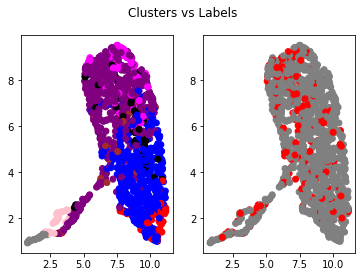

In [242]:
plot(model, torch.FloatTensor(X_train).to(args.device), y_train, labels=None)

In [83]:
print(z_val, q_val)
q_labels = torch.argmax(q_val, axis=1).data.cpu().numpy()
km_labels = kmeans.fit_predict(z_val.data.cpu().numpy())
print(km_labels)
print(nmi_score(q_labels, km_labels))

tensor([[ 0.3419,  2.1053, -0.6603,  ..., -0.4839, -0.1282,  0.0313],
        [-0.0090,  2.0051, -0.5445,  ..., -0.0861,  0.2605,  0.1039],
        [-0.3041,  1.4197, -0.3802,  ..., -0.2679,  0.3264, -0.3431],
        ...,
        [ 0.0938,  2.0480, -0.2896,  ..., -0.2714, -0.1084, -0.0495],
        [ 0.2282,  2.2892, -0.5455,  ..., -0.4342,  0.1029, -0.1579],
        [-0.1288,  1.0017, -0.2808,  ...,  0.1140,  0.2142, -0.1672]],
       grad_fn=<AddmmBackward>) tensor([[0.3391, 0.5618, 0.0991],
        [0.3746, 0.5259, 0.0995],
        [0.3213, 0.4794, 0.1993],
        ...,
        [0.4483, 0.4203, 0.1314],
        [0.2534, 0.6727, 0.0739],
        [0.4310, 0.2258, 0.3432]], grad_fn=<TBackward>)
[0 2 2 ... 2 0 1]
0.6851140266630791


Training data


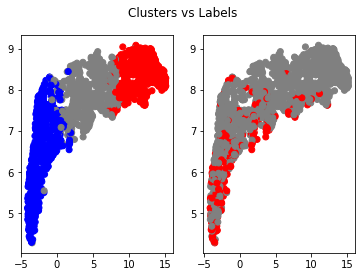

Cluster #  0 sized:  2200
[('Age', 0.147), ('BUN_last', 0.146), ('GCS_last', 0.09), ('HCO3_last', 0.052), ('MechVentStartTime', 0.05), ('GCS_first', 0.049), ('CSRU', 0.041), ('Temp_median', 0.037), ('Glucose_last', 0.029), ('FiO2_last', 0.02)]

Cluster #  1 sized:  2194
[('MechVentStartTime', 0.186), ('Age', 0.115), ('GCS_last', 0.07), ('BUN_first', 0.064), ('Temp_median', 0.055), ('GCS_first', 0.051), ('MechVentLast8Hour', 0.031), ('PaO2_first', 0.03), ('BUN_last', 0.029), ('Glucose_last', 0.022)]

Cluster #  2 sized:  2356
[('GCS_last', 0.236), ('Age', 0.089), ('HCO3_last', 0.071), ('Lactate_last', 0.07), ('Bilirubin_last', 0.063), ('Length_of_stay', 0.057), ('BUN_last', 0.045), ('GCS_highest', 0.039), ('BUN_first', 0.037), ('ALP_last', 0.027)]



In [84]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################

plot(model, torch.FloatTensor(X_train).to(args.device), y_train, labels=None)

regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
q_train = qs[0]
cluster_ids = torch.argmax(q_train, axis=1)
preds_e = torch.zeros((len(z_train), 2))
feature_importances = np.zeros((args.n_clusters, args.input_dim))

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    # X_cluster = z_test[cluster_id]
    X_cluster = z_train
    cluster_preds = model.classifiers[j][0](X_cluster)
    # print(q_test, cluster_preds[:,0])
    preds_e[:,0] += q_train[:,j]*cluster_preds[:,0]
    preds_e[:,1] += q_train[:,j]*cluster_preds[:,1]

for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = X_train[cluster_id]
    if args.attention == True:
        y_cluster = preds_e[cluster_id][:,1]
    else:
        y_cluster = preds[cluster_id][:,1]

    # Some test data might not belong to any cluster
    if len(cluster_id) > 0:
        regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
        best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
        feature_importances[j,:] = regs[j].feature_importances_
        print("Cluster # ", j, "sized: ", len(cluster_id))
        print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
        print("=========================\n")


## Baseline Model

In [626]:
f1_scores, auc_scores = [], []

for r in range(5):
    m = NNClassifier(args, input_dim=89)
    device = args.device

    N_EPOCHS = args.n_epochs
    es = EarlyStopping(dataset=args.dataset, path="./pretrained_model/checkpoint_base")

    kmeans = KMeans(n_clusters=args.n_classes, n_init=20)

    for e in range(1, N_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        m.train()
        nmi, acc, ari = 0, 0, 0

#         for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = torch.FloatTensor(X_train), torch.Tensor(y_train).type(torch.LongTensor)
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        f1 = f1_score(np.argmax(y_pred, axis=1), y_batch)
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()


        m.classifier.eval()
        val_pred = m(torch.FloatTensor(X_val).to(args.device))
        val_loss = nn.CrossEntropyLoss(reduction='mean')(val_pred, torch.Tensor(y_val).type(torch.LongTensor))

        val_f1 = f1_score(torch.argmax(val_pred, axis=1), y_val)
        val_auc = roc_auc_score(y_val, val_pred[:,1].data.cpu().numpy())
        es([val_f1, val_auc], m)

        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
            f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
            f'Val F1: {val_f1:.3f} | Val Acc: {val_auc:.3f} | Val Loss: {val_loss:.3f}')

        if es.early_stop == True:
            break


    ###################################### Testing #####################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data")

    # Load best model trained from local training phase
    m = es.load_checkpoint(m)
    m.classifier.eval()
    test_pred = m.classifier(torch.FloatTensor(X_test))
    test_loss = nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.Tensor(y_test).type(torch.LongTensor))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
    test_auc = roc_auc_score(y_test, test_pred[:,1].detach().numpy())
    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    
    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
        f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
        f'Test F1: {test_f1:.3f} | Test Acc: {test_auc:.3f} | Test Loss: {test_loss:.3f}')


#     reg = GradientBoostingRegressor(random_state=0)

#     reg.fit(X_test, y_test)
#     best_features = np.argsort(reg.feature_importances_)[::-1][:10]
#     print("Best Features ")
#     print(column_names[best_features])
#     print("=========================\n")
print(f1_scores, auc_scores)
print("Avg. Test F1 = {:.3f}, AUC = {:.3f}".format(np.average(f1_scores), np.average(auc_scores)))

Epoch 001: | Train Loss: 0.01984 |  Train F1: 0.000 | Train Acc: 0.018|  Val F1: 0.000 | Val Acc: 0.559 | Val Loss: 0.564
Epoch 002: | Train Loss: 0.01951 |  Train F1: 0.000 | Train Acc: 0.019|  Val F1: 0.000 | Val Acc: 0.588 | Val Loss: 0.554
Epoch 003: | Train Loss: 0.01918 |  Train F1: 0.000 | Train Acc: 0.020|  Val F1: 0.000 | Val Acc: 0.602 | Val Loss: 0.544
Epoch 004: | Train Loss: 0.01884 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.612 | Val Loss: 0.534
Epoch 005: | Train Loss: 0.01849 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.614 | Val Loss: 0.524
EarlyStopping counter: 1 out of 7
Epoch 006: | Train Loss: 0.01813 |  Train F1: 0.000 | Train Acc: 0.022|  Val F1: 0.000 | Val Acc: 0.612 | Val Loss: 0.512
EarlyStopping counter: 2 out of 7
Epoch 007: | Train Loss: 0.01776 |  Train F1: 0.000 | Train Acc: 0.022|  Val F1: 0.000 | Val Acc: 0.609 | Val Loss: 0.500
EarlyStopping counter: 3 out of 7
Epoch 008: | Train Loss: 0.01735 |  Train F1

Epoch 044: | Train Loss: 0.00942 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.606 | Val Loss: 0.259
Epoch 045: | Train Loss: 0.00941 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.608 | Val Loss: 0.259
Epoch 046: | Train Loss: 0.00940 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.609 | Val Loss: 0.258
Epoch 047: | Train Loss: 0.00938 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.610 | Val Loss: 0.258
Epoch 048: | Train Loss: 0.00936 |  Train F1: 0.000 | Train Acc: 0.022|  Val F1: 0.000 | Val Acc: 0.612 | Val Loss: 0.257
Epoch 049: | Train Loss: 0.00934 |  Train F1: 0.000 | Train Acc: 0.022|  Val F1: 0.000 | Val Acc: 0.614 | Val Loss: 0.257

####################################################################################

Evaluating Test Data
Loading Best model with score:  [0.0, 0.6135114589475008]
Epoch 049: | Train Loss: 0.00934 |  Train F1: 0.000 | Train Acc: 0.022|  Test F1: 0.000 | Test Acc: 0.